In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# Load the full dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load dataset
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# DataLoader (full train set, we are not using it)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=256,
    shuffle=True
)

# Test dataset
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Test DataLoader
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    shuffle=False 
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 9.22MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 251kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.78MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [42]:
# selecting a part of the dataset
small_indices = torch.randperm(len(trainset))[:6000]
small_dataset = torch.utils.data.Subset(trainset, small_indices)

train_size = 5000
val_size = 1000

train_dataset, val_dataset = torch.utils.data.random_split(
    small_dataset, [train_size, val_size]
)

train_dataset = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True
)

In [43]:
class MLP_MNIST(nn.Module):
    def __init__(self, nl=2, h=128):
        super(MLP_MNIST, self).__init__()
        
        if nl == 2:
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(28*28, 2*h),  # Input -> Hidden 1
                nn.ReLU(),
                nn.Linear(2*h, h),      # Hidden 1 -> Hidden 2
                nn.ReLU(),
                nn.Linear(h, 10)        # Hidden 2 -> Output
            )
            
        elif nl == 1:
            self.net = nn.Sequential(
                nn.Flatten(),
                nn.Linear(28*28, h),    # Input -> Hidden
                nn.ReLU(),
                nn.Linear(h, 10)        # Hidden -> Output
            )
        
        else:
            raise ValueError("nl must be 1 or 2")

    def forward(self, x):
        return self.net(x)


# Instantiate model
model = MLP_MNIST().to(device)
print(model)

MLP_MNIST(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [44]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002) # Learning rate = 0.001

In [45]:
num_epochs = 15 # Number of times to iterate over the training dataset
training_losses = [] # To store loss values for plotting

print("Starting Training...")
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataset, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if (i + 1) % 200 == 0: # Print every 200 mini-batches
            avg_loss = running_loss / 200
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_dataset)}], Loss: {avg_loss:.4f}')
            training_losses.append({"epoch": epoch + (i+1)/len(train_dataset), "loss": avg_loss})
            running_loss = 0.0

print('Finished Training')

Starting Training...
Finished Training


In [46]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate gradients
with torch.no_grad():
    model.eval() # Set model to evaluation mode
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')


Accuracy of the network on the 10000 test images: 93.66 %


In [47]:
# Metrics tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [48]:
# Validation loader (if not already defined)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)


# Overfitting Experiments

We compare three setups:

1. **No regularization**
2. **L2 regularization (weight decay)**
3. **Dropout**

Goal:
- Visualize overfitting
- Understand how regularization improves generalization


In [49]:
def run_experiment(model, optimizer, num_epochs, l1_lambda=0.0):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_dataset:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Base loss
            loss = criterion(outputs, labels)

            # ---- ADD L1 HERE ----
            if l1_lambda > 0:
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + l1_lambda * l1_norm
            # ---------------------

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dataset)
        train_acc = 100 * correct / total

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)  # no L1 during validation

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(valloader)
        val_acc = 100 * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs


In [50]:
# 1. No Regularization
model_plain = MLP_MNIST().to(device)
optimizer_plain = torch.optim.Adam(model_plain.parameters(), lr=0.002)

# 2. L2 Regularization
model_l2 = MLP_MNIST().to(device)
optimizer_l2 = torch.optim.Adam(model_l2.parameters(), lr=0.002, weight_decay=2e-4)

# 3. Dropout Model
class MLP_Dropout(nn.Module):
    def __init__(self, h=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 2*h),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2*h, h),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(h, 10),
        )
    def forward(self, x):
        return self.net(x)
    
model_dropout = MLP_Dropout().to(device)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.002)


# 4. L1 Regularization
model_l1 = MLP_MNIST().to(device)
optimizer_l1 = torch.optim.Adam(model_l1.parameters(), lr=0.002)

In [51]:
num_epochs = 20

results_plain = run_experiment(model_plain, optimizer_plain, num_epochs)
results_l2 = run_experiment(model_l2, optimizer_l2, num_epochs)
results_l1 = run_experiment(model_l1, optimizer_l1, num_epochs, l1_lambda = 1e-5)
results_dropout = run_experiment(model_dropout, optimizer_dropout, num_epochs)

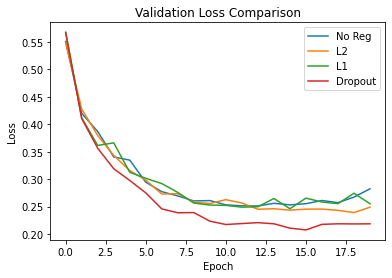

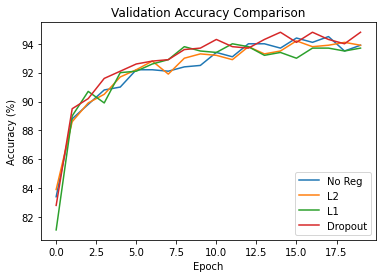

In [52]:
import matplotlib.pyplot as plt

def plot_comparison(res1, res2, res3, res4, title, ylabel):
    plt.figure()
    plt.plot(res1, label="No Reg")
    plt.plot(res2, label="L2")
    plt.plot(res3, label="L1")
    plt.plot(res4, label="Dropout")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Loss comparison
plot_comparison(results_plain[1], results_l2[1], results_l1[1], results_dropout[1],
                "Validation Loss Comparison", "Loss")

# Accuracy comparison
plot_comparison(results_plain[3], results_l2[3], results_l1[3], results_dropout[3],
                "Validation Accuracy Comparison", "Accuracy (%)")


In [27]:
# Final Evaluation on Test Set

def evaluate_on_test(model, name):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{name} Test Accuracy: {accuracy:.2f}%")
    return accuracy


print("=== Final Test Set Evaluation ===")
acc_plain = evaluate_on_test(model_plain, "No Regularization")
acc_l2 = evaluate_on_test(model_l2, "L2 Regularization")
acc_l1 = evaluate_on_test(model_l1, "L1 Regularization")
acc_dropout = evaluate_on_test(model_dropout, "Dropout")


=== Final Test Set Evaluation ===
No Regularization Test Accuracy: 93.95%
L2 Regularization Test Accuracy: 94.33%
L1 Regularization Test Accuracy: 94.24%
Dropout Test Accuracy: 94.52%


# Reduced Dataset

In [61]:
import torch
from torch.utils.data import Subset
import random

# Suppose you want 10% of the dataset
subset_size = int(0.1 * len(trainset))
indices = random.sample(range(len(trainset)), subset_size)

train_subset = Subset(trainset, indices)

train_dataset = torch.utils.data.DataLoader(
    train_subset,
    batch_size=256,
    shuffle=True
)

In [62]:
num_epochs = 20

results_plain = run_experiment(model_plain, optimizer_plain, num_epochs)
results_l2 = run_experiment(model_l2, optimizer_l2, num_epochs)
results_l1 = run_experiment(model_l1, optimizer_l1, num_epochs, l1_lambda = 1e-5)
results_dropout = run_experiment(model_dropout, optimizer_dropout, num_epochs)

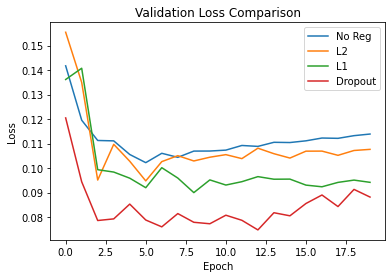

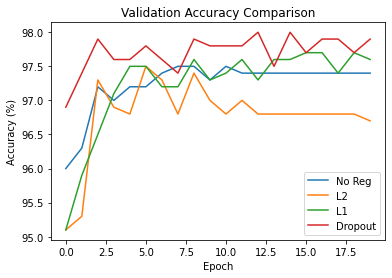

In [63]:
plot_comparison(results_plain[1], results_l2[1], results_l1[1], results_dropout[1],
                "Validation Loss Comparison", "Loss")

# Accuracy comparison
plot_comparison(results_plain[3], results_l2[3], results_l1[3], results_dropout[3],
                "Validation Accuracy Comparison", "Accuracy (%)")